This notebook is intended to explore the 1.1.3.15 data and figure out the storyline.<br/><br/>Copyright (C) 2019  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [2]:
import json
import re
import random
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import matplotlib
import matplotlib.gridspec as gridspec
# import seaborn as sns; sns.set(style="ticks", color_codes=True)

import sklearn
# from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import networkx as nx
from brenparse import parser

from collections import Counter

import string
import matplotlib.gridspec as gridspec
from cycler import cycler

font_size = 6.5

#### Load the 1.1.3.15 sequences encoded using UniRep embeddings

In [29]:
def load_unirep(uni_filepath, prop_filepath, ec='1.1.3.15', sep='\t'):
    '''
    Load unirep embeddings into a data frame
    '''
    # load data and drop duplicates
    unirep = pd.read_csv(uni_filepath, sep=sep)

    # replace the first column with identifiers
    unirep['Unnamed: 0'] = [i.split(';')[0] for i in unirep['Unnamed: 0']]

    # re-name column
    unirep = unirep.rename(columns={'Unnamed: 0':'uid'}).drop_duplicates()

    # load uid to ec mapping and merge with property data
    uid_ec = pd.read_csv(prop_filepath, sep='\t').drop_duplicates()

    # merge with ec data
    unirep_merged = unirep.merge(uid_ec, on='uid')

    # keep only a certain ec
    if ec == 'all':
        df_unirep = unirep_merged.drop('ec', axis=1)
    else:
        df_unirep = unirep_merged[unirep_merged.ec==ec].drop('ec', axis=1)

    return df_unirep


df_unirep = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2017_1', '1_1_3_15_BRENDA_sequences_2017_1_unirep.csv'),
                       prop_filepath=join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv'),
                       ec='1.1.3.15')

# exclude A0A0D2NBS0 which is clearly weird (long R-stretches, long S-stretches etc.)
df_unirep = df_unirep[df_unirep.uid != 'A0A0D2NBS0']

display(df_unirep.head())
display(df_unirep.tail())
display(df_unirep.shape)

,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
0,Q9LRS0,0.015368,0.207102,0.076687,-0.040839,-0.116888,0.069290,0.011434,-0.046359,-0.004900,...,0.314290,0.790593,-0.073425,0.092051,-2.026682,-0.509704,0.087242,-1.506297,0.134525,0.133366
1,Q9NYQ3,0.008693,0.174844,0.069413,-0.042212,-0.134430,0.074950,0.001461,-0.043215,-0.005424,...,0.089248,-0.263058,-0.042254,1.496965,-5.197642,-0.705786,0.733264,-2.503107,0.237558,0.250491
2,P37339,0.024516,0.012727,0.070111,-0.008737,-0.356430,0.079726,-0.072076,0.021245,-0.004387,...,0.002008,-0.151272,-0.355469,0.982859,-12.764032,0.079448,0.277421,-0.994417,0.123666,4.128017
3,Q24JJ8,0.011160,0.157242,0.094497,-0.049337,-0.101914,0.079308,0.020020,-0.047959,-0.003755,...,0.467036,0.284698,-0.034987,0.619066,0.641803,-1.148381,-0.318683,-2.219294,0.175722,0.342891
4,B8AUI3,0.015618,0.195818,0.077877,-0.038937,-0.114840,0.062852,0.023075,-0.044319,-0.004918,...,0.174401,-0.260186,-0.017469,0.329008,-3.487090,-0.563792,-1.393174,-1.276244,0.272284,-0.236023


,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
1516,A9QH71,0.009455,0.219847,0.103803,-0.050824,-0.151323,0.089220,-0.036848,-0.034098,-0.005225,...,-0.157484,0.843791,-1.082652,0.641018,0.119639,-1.160658,0.113825,-2.279773,-1.942494,-0.435205
1517,Q19U05,0.024040,0.254216,0.050659,-0.049643,-0.134535,0.074266,-0.052019,-0.056929,-0.005444,...,0.651206,0.978142,-0.146856,-0.111661,-2.068116,-0.396004,0.252551,-1.376392,0.154752,-0.612745
1518,Q56ZN0,0.012550,0.002016,0.073650,-0.019503,-0.178365,0.075036,-0.105890,-0.036631,-0.012694,...,-0.030956,0.652134,-0.331385,0.187544,-7.920573,1.363386,-0.819463,0.167937,1.640501,-0.594091
1519,Q9CG58,0.013375,0.151428,0.068151,-0.040234,-0.185928,0.091063,-0.046391,-0.040538,-0.005390,...,0.472638,0.943564,-0.594634,0.482974,-4.980826,-1.161522,0.885641,-1.171054,-0.503927,-0.224051
1520,Q5SM78,0.006447,0.011494,0.019374,-0.024663,0.129485,0.051069,-0.339259,-0.028680,-0.008576,...,-0.817561,-0.619731,-3.377041,1.294016,-3.438803,-0.503037,1.146056,2.180844,3.405272,-0.993078


(1520, 5701)

#### Load the enzyme property data

In [30]:
# load enzyme property information
filepath = join(FINAL, 'brenda_2017_1', '1-1-3-n_identifier_info_2017_1.tsv')
uid_property = pd.read_csv(filepath, sep='\t').drop_duplicates()

uid_property.drop(['lineage_identifiers', 'lineage_ranks', 'lineage_names'], 
                  inplace=True,
                 axis=1)

# load uid to ec mapping and merge with property data
filepath = join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv')
uid_ec = pd.read_csv(filepath, sep='\t').drop_duplicates()

# merge with the ec mapping
uid_data = uid_property.merge(uid_ec, on=['uid'])

# sort in the same order as the unirep data
uid_data['sort_cat'] = pd.Categorical(uid_data['uid'], 
                                          categories=df_unirep.uid, 
                                          ordered=True)
uid_data.sort_values('sort_cat', inplace=True)
uid_data.reset_index(inplace=True)

# exclude A0A0D2NBS0 which is clearly weird (long R-stretches, long S-stretches etc.)
uid_data = uid_data[uid_data.uid != 'A0A0D2NBS0']

# drop columns that aren't needed
uid_data = uid_data.drop(['sort_cat', 'index'], axis=1)

display(uid_data.head())
display(uid_data.tail())

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
2937,N0CVG9,1303692.0,Streptomyces fulvissimus,Bacteria,7.20,28.0,PF09118,1.1.3.9
2938,N0CMJ7,1303692.0,Streptomyces fulvissimus,Bacteria,7.20,28.0,PF09118,1.1.3.9
2939,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9
2940,C5CYJ5,543728.0,Variovorax paradoxus,Bacteria,6.91,28.0,PF09118,1.1.3.9
2941,G2DAI4,1048808.0,Endosymbiont of,Bacteria,NaN,NaN,NaN,1.1.3.9


#### Load experimental data and combine with enzyme property data

In [31]:
filepath = join(FINAL, 'experiments')

batch1 = pd.read_csv(join(filepath, '1-1-3-n_batch1_summary.tsv'), sep='\t')
batch2 = pd.read_csv(join(filepath, '1-1-3-n_batch2_summary.tsv'), sep='\t')

# rename the column for the identifier
batch1.rename(columns={'node':'uid'}, inplace=True)
batch2.rename(columns={'name':'uid'}, inplace=True)

# add info on which batch it is
batch1['batch'] = 'first'
batch2['batch'] = 'second'

# check that there are no duplicates
for uid in batch1.uid.values:
    if uid in batch2.uid.values:
        print('Bad overlap, uid %s exists in both datasets' % uid)
    

# combine them 
both_batches = batch1.append(batch2).drop_duplicates()

# use True and False instead of Yes and No
both_batches = both_batches.replace(True, 'Yes', regex=True)
both_batches = both_batches.replace(False, 'No', regex=True)

# drop unnessecary columns
both_batches = both_batches[(both_batches['synthesized'] == 'Yes') |
                            (both_batches['synthesized'] == 'No')]
both_batches.drop(['rep1_soluble', 
                   'rep1_active', 
                   'rep2_soluble', 
                   'rep2_active', 
                   'rep3_soluble', 
                   'rep3_active'], axis=1, inplace=True)
    
display(both_batches.head())

    
# now merge with the other data
uid_data = uid_data.merge(both_batches, on='uid', how='left')

# replace empty strings with nans
uid_data = uid_data.replace('', np.nan, regex=True)

display(uid_data.head())
display(uid_data.tail())

,uid,synthesized,substrate_available,total_soluble,total_active,batch
0,A0A009NBJ7,Yes,Yes,No,NaN,first
1,A0A011R8E6,Yes,Yes,No,NaN,first
2,A0A017H745,Yes,Yes,No,NaN,first
3,A0A024H7W1,Yes,Yes,Yes,Yes,first
4,A0A073CBY9,Yes,Yes,Yes,No,first


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
2936,N0CVG9,1303692.0,Streptomyces fulvissimus,Bacteria,7.20,28.0,PF09118,1.1.3.9,NaN,NaN,NaN,NaN,NaN
2937,N0CMJ7,1303692.0,Streptomyces fulvissimus,Bacteria,7.20,28.0,PF09118,1.1.3.9,NaN,NaN,NaN,NaN,NaN
2938,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9,Yes,Yes,No,NaN,second
2939,C5CYJ5,543728.0,Variovorax paradoxus,Bacteria,6.91,28.0,PF09118,1.1.3.9,NaN,NaN,NaN,NaN,NaN
2940,G2DAI4,1048808.0,Endosymbiont of,Bacteria,NaN,NaN,NaN,1.1.3.9,NaN,NaN,NaN,NaN,NaN


#### Load data on the substrate-level

In [32]:
# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), 
                    sep=';', 
                    index_col=None)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), 
                    sep=';', 
                    index_col=None)
data = data1.append(data2)

# change True to Yes and False to No
data.replace(True, 'Yes', regex=False, inplace=True)
data.replace(False, 'No', regex=False, inplace=True)

# re-name protein column
data.rename(columns={'protein':'uid'}, inplace=True)

# combine with all the other data from 1.1.3.15
uid_data_subset = uid_data[uid_data['ec']=='1.1.3.15']
prop_data = uid_data_subset.merge(data, 
                     on='uid', 
                     how='left')

display(prop_data.head())
display(prop_data.tail())
display(prop_data.describe())
display(prop_data.shape)

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,taxid,ph,temperature
count,1.334000e+03,805.000000,1068.000000
mean,6.339865e+05,7.019752,33.602996
std,5.358970e+05,0.452941,7.146458
min,1.950000e+02,1.500000,10.000000
25%,7.696300e+04,7.000000,29.000000
50%,5.421690e+05,7.010000,36.000000
75%,1.116108e+06,7.120000,37.000000
max,2.500155e+06,9.000000,90.000000


(1520, 19)

In [33]:
def get_all_uniprot_id_brenparse(ec='1.1.3.15'):
    '''
    Parse an html file using the brenparse library.
    This allows for parsing of specific tables. Here
    the organism table is used.
    '''

    filepath = join(RAW_EXTERNAL, 'brenda_2019_2', 'html_data', '{}.html'.format(ec))

    soup_obj = parser.open_ec(filepath)
    orgs = parser.Organism(soup_obj)
    
    uids = []
    for entry in orgs.get_data(uid_orgs_only=False).values():
        uids.extend(entry)
    return list(set(uids))
    
    

in_brenda = get_all_uniprot_id_brenparse(ec='1.1.3.15') # BRENDA version 2019.1, all tables



print(in_brenda)

['Q9CG58', 'Q9UJM8', 'Q19U05', 'Q9NYQ2', 'Q24JJ8', 'Q9WU19', 'Q9LRR9', 'A9QH69', 'Q07523', 'Q56ZN0', 'A9QH71', 'Q9LJH5', 'Q10CE4', 'Q9NYQ3', 'B7FUG8']


#### Add information regarding which sequences are marked as characterized in BRENDA

In [34]:
active = []
for uid in in_brenda:
    active.append('Yes')
        
brenda_df = pd.DataFrame({'uid':in_brenda, 'in_brenda':active})
        

# merge with data frame
prop_data = prop_data.merge(brenda_df, on=['uid'], how='left')


# replace nans
prop_data.in_brenda = prop_data.in_brenda.replace(np.nan, 'No', regex=False)

display(prop_data.head())
display(prop_data.tail())


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


#### Add information regarding which sequences are marked as characterized in SwissProt

In [35]:
in_swissprot = pd.read_csv(join(INTERMEDIATE, 'swissprot_2020_02', 'SwissProt-2020_02-protein-evidence.tsv'),
                          sep='\t')

in_swissprot = in_swissprot[in_swissprot['ec']=='1.1.3.15'].uid.values
display(in_swissprot)

active = []
for uid in in_swissprot:
    active.append('Yes')
        
swissprot_df = pd.DataFrame({'uid':in_swissprot, 'in_swissprot':active})
        

# merge with data frame
prop_data = prop_data.merge(swissprot_df, on=['uid'], how='left')


# replace nans
prop_data.in_swissprot = prop_data.in_swissprot.replace(np.nan, 'No', regex=False)

display(prop_data.head())
display(prop_data.tail())

array(['Q9UJM8', 'Q07523', 'Q9NYQ3', 'Q9LRR9', 'Q10CE4', 'Q9NYQ2',
       'Q9WU19', 'P05414', 'O49506', 'Q8H3I4', 'Q9LRS0'], dtype=object)

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No


#### Add information regarding the Pfam domains

In [36]:
# first drop the old pfam data
prop_data = prop_data.drop('pfam', axis=1)

# load up the other pfam data
filepath = join(FINAL, 'brenda_2017_1', 'pfam_info_2017_1.tsv')
pfam_df = pd.read_csv(filepath, sep='\t')

# replace nans
pfam_df = pfam_df.replace(np.nan, '', regex=True)
display(pfam_df.head())
display(pfam_df.describe())

# merge with data frame
prop_data = prop_data.merge(pfam_df, on=['uid'], how='left')

display(prop_data.head())
display(prop_data.tail())


,uid,pfam
0,A0A0U5F9V4,"PF01565,PF02913"
1,S6DC87,"PF01565,PF02913"
2,D4XA33,PF01565
3,D4XA32,"PF01565,PF02913"
4,D4XIR1,"PF01565,PF02913"


,uid,pfam
count,1521,1521
unique,1521,28
top,I9Q9Y3,PF01266
freq,1,677


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,PF01070
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,PF01070
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF01266
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF01070


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF18690


#### Add in data for how identical sequences are compared to the BRENDA ones OR the SwissProt ones

In [37]:
# load up the identity data
df_ident = pd.read_csv(join(FINAL, 'brenda_2017_1', 'all_identity_matrix_ident.tsv'), 
                       sep='\t', 
                      index_col=0)

display(df_ident.head())


# get a list of all the selected identifiers 
selected = prop_data[(prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes')]

# get a list with all the identifiers not selected
not_selected = prop_data[(prop_data.in_brenda == 'No') & (prop_data.in_swissprot == 'No')]

# make sure all the identifiers are present in the identity matrix
for uid in selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

for uid in not_selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

    
# make a subset of the identity matrix
df_ident_selected = df_ident.loc[selected.uid.values]


sim_data = {'uid':[], 'max_database_sim':[]}
for uid in prop_data.uid.values:
    sim_data['uid'].append(uid)
    sim_data['max_database_sim'].append(max(df_ident_selected[uid].values))

sim_data_df = pd.DataFrame(sim_data)
display(sim_data_df.head())

# merge with the other data
prop_data = prop_data.merge(sim_data_df, on=['uid'])
display(prop_data.head())
display(prop_data.tail())

,Q9LRS0,Q9NYQ3,P37339,Q24JJ8,B8AUI3,Q10CE4,Q6YT73,Q9LRR9,Q7XPR4,O49506,...,A0A0P8P4X1,S6AJB3,A0A0N7LTA8,D5MNA0,A9QH69,A9QH71,Q19U05,Q56ZN0,Q9CG58,Q5SM78
Q9LRS0,100.0,45.7,14.1,59.0,79.6,83.5,85.6,95.1,69.0,84.0,...,16.6,15.2,15.4,15.0,32.7,31.8,43.1,19.6,36.4,15.3
Q9NYQ3,45.7,100.0,14.8,46.6,44.6,44.9,45.4,45.9,41.7,45.8,...,15.0,15.9,15.8,15.9,28.2,27.3,25.8,11.4,30.7,11.3
P37339,14.1,14.8,100.0,13.0,14.6,17.1,17.7,15.1,13.8,17.1,...,88.2,15.8,51.8,14.9,14.2,13.3,10.1,5.7,15.5,14.1
Q24JJ8,59.0,46.6,13.0,100.0,59.4,59.9,59.9,59.0,59.5,59.3,...,14.0,15.0,12.4,14.6,33.2,31.9,28.6,13.2,35.9,13.8
B8AUI3,79.6,44.6,14.6,59.4,100.0,82.9,84.3,81.5,76.1,81.6,...,14.3,15.2,16.9,15.4,34.4,33.5,40.0,17.4,36.0,14.7


,uid,max_database_sim
0,Q9LRS0,100.0
1,Q9NYQ3,100.0
2,P37339,17.1
3,Q24JJ8,100.0
4,B8AUI3,82.9


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam,max_database_sim
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,PF01070,100.0
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,PF01070,100.0
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF01266,17.1
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF01070,82.9


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam,max_database_sim
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,PF18690,20.5


#### Add in data for how identical sequences are compared to the active ones

In [38]:
# get a list of all the selected identifiers 
selected = prop_data[prop_data.total_active == 'Yes']

# get a list with all the identifiers not selected
not_selected = prop_data[prop_data.total_active == 'No']

# make sure all the identifiers are present in the identity matrix
for uid in selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

for uid in not_selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

    
# make a subset of the identity matrix
df_ident_selected = df_ident.loc[selected.uid.values]


sim_data = {'uid':[], 'max_active_sim':[]}
for uid in prop_data.uid.values:
    sim_data['uid'].append(uid)
    sim_data['max_active_sim'].append(max(df_ident_selected[uid].values))

sim_data_df = pd.DataFrame(sim_data)
display(sim_data_df.head())

# merge with the other data
prop_data = prop_data.merge(sim_data_df, on=['uid'])
display(prop_data.head())
display(prop_data.tail())

,uid,max_active_sim
0,Q9LRS0,38.5
1,Q9NYQ3,37.7
2,P37339,98.6
3,Q24JJ8,36.6
4,B8AUI3,37.8


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam,max_database_sim,max_active_sim
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,Yes,PF01070,100.0,38.5
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,Yes,PF01070,100.0,37.7
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,PF01266,17.1,98.6
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0,36.6
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,PF01070,82.9,37.8


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,pfam,max_database_sim,max_active_sim
1515,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0,95.8
1516,Q19U05,74825.0,Pachysandra terminalis,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0,21.2
1517,Q56ZN0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0,9.6
1518,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,PF01070,100.0,44.8
1519,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,PF18690,20.5,17.5


#### Add in data for how identical sequences are compared BRENDA + SwissProt + active ones

In [39]:

prop_data['max_all_sim'] = prop_data[['max_database_sim', 'max_active_sim']].max(axis=1)


### Remove duplicates from the dataset

In [40]:
# make sure the unirep df has the same identifiers as the property df
df_unirep = df_unirep[df_unirep['uid'].isin(prop_data['uid'].values)].reset_index(drop=True)

# find duplicated items
dups = df_unirep.drop('uid', axis=1).duplicated()

# get the identifiers of duplicates
dup_ids = df_unirep[dups].uid.values

# any of these in my selected sequences?
display(set(prop_data[prop_data['synthesized'] == 'Yes'].uid.values) & set(dup_ids))

# if not I can remove duplicates
df_unirep_nodups = df_unirep.drop('uid', axis=1).drop_duplicates()

# get the index of remaining and make subset
df_unirep = df_unirep.loc[df_unirep_nodups.index.values]
prop_data = prop_data[prop_data.uid.isin(df_unirep.uid.values)]

set()

In [41]:
# just a sanity check that they are in the same order
for i in range(len(prop_data.uid.values)):
    assert(prop_data.uid.values[i]==df_unirep.uid.values[i])

In [42]:
# check if all the superkingdom designations are ok
prop_data[prop_data['superkingdom'].isnull()]

# I've looked at these manually and they are all bacterial
prop_data.loc[prop_data['superkingdom'].isnull(), 'superkingdom'] = 'Bacteria'

# save to file, for future reference
prop_data.to_csv(join(FINAL, 'brenda_2017_1', 'all_prop_data_for_figures.tsv'), 
                 index=False, 
                 sep='\t',
                 na_rep='NA')

In [43]:
prop_data.shape

(1175, 24)

In [44]:
df_unirep.shape

(1175, 5701)

#### Convert UniRep data to matrix

In [45]:
# make a matrix
plot_data = df_unirep.drop(['uid'], axis=1)
plot_data = plot_data.values
plot_data

array([[ 1.5367617e-02,  2.0710224e-01,  7.6687050e-02, ...,
        -1.5062973e+00,  1.3452520e-01,  1.3336562e-01],
       [ 8.6932690e-03,  1.7484409e-01,  6.9413430e-02, ...,
        -2.5031066e+00,  2.3755798e-01,  2.5049123e-01],
       [ 2.4516402e-02,  1.2727179e-02,  7.0110530e-02, ...,
        -9.9441690e-01,  1.2366584e-01,  4.1280174e+00],
       ...,
       [ 1.2549669e-02,  2.0163613e-03,  7.3649590e-02, ...,
         1.6793665e-01,  1.6405010e+00, -5.9409130e-01],
       [ 1.3374525e-02,  1.5142758e-01,  6.8150730e-02, ...,
        -1.1710538e+00, -5.0392723e-01, -2.2405082e-01],
       [ 6.4473613e-03,  1.1493544e-02,  1.9374004e-02, ...,
         2.1808438e+00,  3.4052722e+00, -9.9307775e-01]])

#### Calculate an MDS visualization

In [46]:
my_plot = MDS(n_components=2, 
          random_state=42).fit_transform(plot_data)

#### Setup the colors I want

In [5]:
eukaryota = '#b15928'
bacteria = '#cab2d6'
archaea = '#6a3d9a'
other = '#c8c8c8'


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'

cluster0 = '#077084'
cluster1 = '#06a1f7'
cluster2 = '#8214a0'
cluster3 = '#fa78fa'
cluster4 = '#aa0a3c'
cluster5 = '#fa7850'
cluster6 = '#0ab45a'
cluster7 = '#a0fa82'
cluster8 = '#f0f032'
cluster9 = '#fae6be'

colors = (cluster0, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9)

selected = '#069f73'
insoluble = '#5b5b5b'
inactive = '#e79f26'
active = '#069f73'

brenda = 'black'

# set up some plotting parameters
small_point = 2
large_point = 4

In [48]:
# take a look at pfam domains
display(prop_data[['pfam', 'uid']].groupby('pfam').count())

# save to table
prop_data[['pfam', 'uid']].groupby('pfam').count().reset_index().to_csv(join(FINAL, 'brenda_2017_1', 'pfam_domain_count.tsv'), sep='\t')

,uid
pfam,
,17
"CL0100,PF01266",2
"CL1350,PF01266",1
"PF00109,PF00550,PF00698,PF02801,PF08659,PF16197",8
"PF00109,PF00550,PF02801,PF08659,PF16197",6
"PF00109,PF00550,PF02801,PF08659,PF16197,PF95024",1
"PF00155,PF01070",2
"PF00173,PF01070",5
"PF00301,PF01070",2


In [49]:
prop_data[['superkingdom', 'uid']].groupby('superkingdom').count()

,uid
superkingdom,
Archaea,27
Bacteria,1049
Eukaryota,93
None,3
hydrocarbon metagenome,1
hydrothermal vent metagenome,2


In [50]:
prop_data[['total_active', 'uid']].groupby('total_active').count()

,uid
total_active,
No,44
Yes,21


In [4]:
def cm2inch(*tupl):
    '''
    https://stackoverflow.com/questions/14708695/specify-figure-size-in-centimeter-in-matplotlib
    '''
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
    
def mm2inch(*tupl):
    '''
    Convert mm to inches.
    '''
    inch = 25.4
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [ ]:
np.where(my_plot[:,1] == my_plot[:,1].min())

my_plot[971]

In [ ]:
prop_data.iloc[971]

### Figure 1

PF01070 PF01070 29
PF01070 PF01266 14
PF01070 PF01565 15
PF01070 PF01565PF02913 14
PF01070 PF01266PF04324 14
PF01070 PF02754 13
PF01266 PF01266 53
PF01266 PF01565 15
PF01266 PF01565PF02913 15
PF01266 PF01266PF04324 21
PF01266 PF02754 13
PF01565 PF01565 30
PF01565 PF01565PF02913 19
PF01565 PF01266PF04324 15
PF01565 PF02754 13
PF01565PF02913 PF01565PF02913 35
PF01565PF02913 PF01266PF04324 16
PF01565PF02913 PF02754 12
PF01266PF04324 PF01266PF04324 40
PF01266PF04324 PF02754 12
PF02754 PF02754 49


/home/martin/miniconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


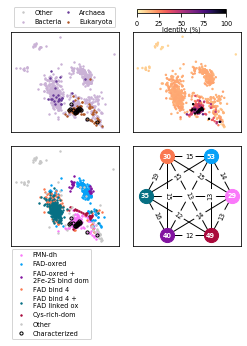

In [52]:


translation = {'PF01070':'FMN-dh', 'PF01266':'FAD-oxred', 'PF01565':'FAD bind 4',
              'PF01565,PF02913':'FAD bind 4 + \nFAD linked ox', 'PF01266,PF04324':'FAD-oxred + \n2Fe-2S bind dom', 
               'PF02754':'Cys-rich-dom', 'other':'Other', 'characterized':'Characterized'
              }



# define colors
dom_color_dict = {'PF01070':cluster3, 
                  'PF01266':cluster1, 
                  'PF01565':cluster5, 
                  'PF01565PF02913':cluster0, 
                  'PF01266PF04324':cluster2, 
                  'PF02754':cluster4,
                  'other':other}


fig = plt.figure(figsize=mm2inch((90, 125)))



#################
## First panel ##
#################

plt.subplot(2, 2, 1)

# Plot of superkingdoms distribution
bac = prop_data.superkingdom == 'Bacteria'
arc = prop_data.superkingdom == 'Archaea'
euk = prop_data.superkingdom == 'Eukaryota'
oth = [not any(s) for s in zip(bac, arc, euk)]
bren = (prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes') # characterized in brenda or wsissprot


plt.scatter(my_plot[:,0][oth], my_plot[:,1][oth], s=small_point, color=other)
plt.scatter(my_plot[:,0][bac], my_plot[:,1][bac], s=small_point, color=bacteria)
plt.scatter(my_plot[:,0][arc], my_plot[:,1][arc], s=small_point, color=archaea)
plt.scatter(my_plot[:,0][euk], my_plot[:,1][euk], s=small_point, color=eukaryota)

# characterized
plt.scatter(my_plot[:,0][bren], my_plot[:,1][bren], s=large_point*2.5,
                linewidths=1,
                facecolor='#00000000', 
                edgecolor='#000000ff')

plt.legend(['Other', 'Bacteria', 'Archaea', 'Eukaryota'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])


##################
## Second panel ##
##################

plt.subplot(2, 2, 2)

sort_mask = np.argsort(prop_data.max_database_sim.values)

sc = plt.scatter(my_plot[:,0][sort_mask], my_plot[:,1][sort_mask], 
                 s=small_point, 
                 c=prop_data.max_database_sim.values[sort_mask], 
                 cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
                 vmin=0,
                 vmax=100)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])
plt.tick_params(labelsize=font_size)

cbaxes = fig.add_axes([0.55, 0.95, 0.35, 0.01]) #[left, bottom, width, height]
cb = fig.colorbar(sc, orientation="horizontal", cax=cbaxes)
cb.ax.tick_params(labelsize=font_size) 
cb.set_label('Identity (%)', 
                     rotation=0, 
                     labelpad=0, 
                     fontsize=font_size) 





#################
## Third panel ##
#################

plt.subplot(2, 2, 3)

PF01070 = prop_data.pfam.values == 'PF01070' # PF01070, FMN dehydrogenase
PF01266 = prop_data.pfam.values == 'PF01266' # PF01266, FAD dependent oxidoreductase family
PF01565 = prop_data.pfam.values == 'PF01565' # PF01565, FAD_binding_4
PF01565PF02913 = prop_data.pfam.values == 'PF01565,PF02913' # FAD_binding_4 AND FAD linked oxidases, C-terminal domain
PF01266PF04324 = prop_data.pfam.values == 'PF01266,PF04324' # FAD dependent oxidoreductase family AND BFD-like [2Fe-2S] binding domain
PF02754 = prop_data.pfam.values == 'PF02754' # PF02754, Cys-rich-dom
background = [not any(s) for s in zip(PF01266, PF01070, PF02754, PF01565, PF01565PF02913, PF01266PF04324)]
bren = (prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes') # characterized in brenda or swissprot


plt.scatter(my_plot[:,0][PF01070], my_plot[:,1][PF01070], 
            s=small_point, 
            color=dom_color_dict['PF01070'])

plt.scatter(my_plot[:,0][PF01266], my_plot[:,1][PF01266], 
            s=small_point, 
            color=dom_color_dict['PF01266'])

plt.scatter(my_plot[:,0][PF01266PF04324], my_plot[:,1][PF01266PF04324], 
            s=small_point, 
            color=dom_color_dict['PF01266PF04324'])

plt.scatter(my_plot[:,0][PF01565], my_plot[:,1][PF01565], 
            s=small_point, 
            color=dom_color_dict['PF01565'])

plt.scatter(my_plot[:,0][PF01565PF02913], my_plot[:,1][PF01565PF02913], 
            s=small_point, 
            color=dom_color_dict['PF01565PF02913'])

plt.scatter(my_plot[:,0][PF02754], my_plot[:,1][PF02754], 
            s=small_point, 
            color=dom_color_dict['PF02754'])

plt.scatter(my_plot[:,0][background], my_plot[:,1][background], 
            s=small_point, 
            color=dom_color_dict['other'])

#characterized
plt.scatter(my_plot[:,0][bren], my_plot[:,1][bren], s=large_point*2.5,
                linewidths=1,
                facecolor='#00000000', 
                edgecolor='#000000ff')

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.legend([translation['PF01070'], translation['PF01266'], translation['PF01266,PF04324'],
            translation['PF01565'], translation['PF01565,PF02913'],  translation['PF02754'], 
            translation['other'], translation['characterized']], 
           fontsize=font_size,
           loc='upper left',
           bbox_to_anchor=(-0.02, 0),
           #mode = 'expand',
           ncol=1)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])



##################
## Fourth panel ##
##################

ax = plt.subplot(2, 2, 4)

# check average identity between the sequences with different domains

# define a list of domains
dom_subsets_names = ['PF01070', 'PF01266', 'PF01565', 'PF01565PF02913', 'PF01266PF04324', 'PF02754']
dom_subsets = [PF01070, PF01266, PF01565, PF01565PF02913, PF01266PF04324, PF02754]



# iterate through each pair of domains and compute the mean
node_data = []
edge_data = []
for i in range(len(dom_subsets)):
    for j in range(len(dom_subsets)):
        
        if i > j:
            continue
            
        id_list_i = prop_data[dom_subsets[i]].uid.tolist()
        id_list_j = prop_data[dom_subsets[j]].uid.tolist()

        # subset the identity matrix
        data_matrix = df_ident.loc[id_list_i, id_list_j]
            
        if i == j: # save to node data structure
            node_data.append((dom_subsets_names[i], int(round(data_matrix.mean().mean()))))

        else: # save to edge data structure
            edge_data.append((dom_subsets_names[i], dom_subsets_names[j], int(round(data_matrix.mean().mean()))))

        print(dom_subsets_names[i], dom_subsets_names[j], int(round(data_matrix.mean().mean())))
        
        
        

# now create a graph
G = nx.Graph()

# add nodes
G.add_nodes_from(dom_subsets_names)

for d in edge_data:
    G.add_edge(d[0], d[1], weight=d[2])

# do the network layout
pos = nx.circular_layout(G) 

# draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=1)

# add weight labels to the edges
labels = nx.get_edge_attributes(G, 'weight')
_ = nx.draw_networkx_edge_labels(G, pos, 
                                 edge_labels=labels,
                                 font_size=font_size)

# draw nodes
for node in dom_subsets_names:
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color=dom_color_dict[node],
                           node_size=200,
                           alpha=1)
    
# add identity within cluster onto the nodes
labels={k:v for k,v in node_data}
nx.draw_networkx_labels(G, pos, 
                        labels, 
                        font_size=font_size,
                        font_color='w',
                        font_weight='bold')


plt.tight_layout()

plt.savefig(join(FIGURES, 'figure1.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'figure1.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## Figure 2 and 3

In [ ]:
import abc_tools
import vislib

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage


In [ ]:
def filter_matrix_for_ids(data_matrix, id_list):
    '''
    Subset a pairwise identity matrix to retain only the desired identifiers.
    '''
    # make sure all the identifiers are present in the identity matrix
    for uid in id_list:
        assert uid in data_matrix.index, 'Error, %s not present in identity matrix' % uid

    for uid in id_list:
        assert uid in data_matrix.index, 'Error, %s not present in identity matrix' % uid


    # make a subset of the identity matrix
    return data_matrix.loc[id_list, id_list]


def den_from_id_matrix(data_matrix, linkage_type='average'):
    '''
    Build a dendrogram from the pre-computed pairwise protein idnetities.
    '''

    # convert the similarity matrix to a distance matrix
    data_dist_matrix = data_matrix.apply(lambda value: 100-value)

    # cut the matrix in half (condensed distance matrix)
    dists = squareform(data_dist_matrix.values)

    # make a linkage matrix
    linkage_matrix = linkage(dists, linkage_type)

    # make dendrogram object
    den = dendrogram(linkage_matrix, labels=data_dist_matrix.index)

    #plt.show()

    return den


# get the dendrogram plotting data coordinates
def extract_plotting_coordinates(den):
    '''
    Get the x, y coordinates for ach index.
    '''
    x_coordinates = den['icoord']
    y_coordinates = den['dcoord']
    index = den['ivl']
    coordinate_data = []
    label_data = {}
    i = 0
    # the dendrogram is drawn as "half boxes" with each point described by a list of four x and four y coordinates
    # extract these for later plotting
    for x_list, y_list in zip(x_coordinates, y_coordinates):
        xy_pairs = zip(x_list, y_list)
        # also want to get the end nodes, where the labels are supposed to go
        pairs = []
        for x, y in xy_pairs:
            pair = (x, y)
            pairs.append(pair)
            # if y is zero, then that is a place where the label should go
            if y == 0.0:
                label_data[index[i]] = pair
                i += 1
        coordinate_data.append(pairs)
    return coordinate_data, label_data


def load_and_normalize_data_new(filepath, xfold_cutoff=5):
    '''
    Use new normalization that keeps information of relative rates.
    '''
    data = pd.read_csv(filepath, index_col = 'protein', sep='\t')

    # rename protein column
    data.index.name = 'uid'

    # subtract the blank from the other activities
    ratio_df = data.sub(data.blank, axis=0)

    # average the three measurements
    by_protein = ratio_df.groupby(by = 'uid')
    meandf = by_protein.mean()
    stdevdf = by_protein.std()

    # take mean of BSA control and add two standard deviations
    meandf.loc['BSA_stdev'] = stdevdf.loc['BSA_control']
    meandf.loc['BSA_mean'] =  meandf.loc['BSA_control']

    # subtract the LOD and only keep what's larger
    hit_df = meandf - meandf.loc['BSA_mean']
    hit_df = hit_df[hit_df > xfold_cutoff*meandf.loc['BSA_stdev']]

    # drop unneeded columns
    hit_df = hit_df.drop(['BSA_control', 'no_protein', 'BSA_stdev', 'BSA_mean'], axis=0)
    hit_df = hit_df.drop(['blank'], axis = 1)

    # drop lines with only nan and replace nan with 0
    hit_df.dropna(how='all', axis=0, inplace=True)
    hit_df = hit_df.replace(np.nan, 0, regex=True)

    # for each enzyme normalize to the highest value
    hit_df_norm = hit_df.div(hit_df.max(axis=1), axis=0)
    
    return hit_df_norm




#### Load batch 1 experiment data

In [ ]:
# set a cutoff for how many times the activity should be of the mean
xfold_cutoff = 4


# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep0.tsv')
data1 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep1_data.tsv')
data2 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath, xfold_cutoff)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
first_batch = by_protein.mean()

# add uid column
first_batch['uid'] = first_batch.index
first_batch.reset_index(drop=True, inplace=True)

display(first_batch)

#### Load batch 2 experiment data

In [ ]:
# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep1.tsv')
data1 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep2.tsv')
data2 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath, xfold_cutoff)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
second_batch = by_protein.mean()

# add uid column
second_batch['uid'] = second_batch.index
second_batch.reset_index(drop=True, inplace=True)

display(second_batch)


#### Combine the two batches and add to property data

In [ ]:
both_batches = pd.concat([first_batch, second_batch])
both_batches = both_batches.reset_index(drop=True)

display(both_batches)
display(both_batches.describe())

### Figure 2a

In [ ]:
# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & (prop_data['pfam'].str.contains('PF01070'))]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color
        
# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
    
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors,
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure2a_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

### Figure 3a

In [ ]:

# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & 
                      (prop_data['pfam'].str.contains('PF01266'))]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color

# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure3a_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

### Figure 3b

In [ ]:

# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & 
                      (prop_data['pfam'].str.contains('PF01070')==False) &
                      (prop_data['pfam'].str.contains('PF01266')==False)]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color
        
# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure3b_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

## Figure 3c

In [ ]:
def remove_redundant_from_pfam(pfam, unirep):
    '''
    Takes a pfam dataframe and one containing unirep embeddings.
    Uses the embeddings to filter out redundant entries.
    '''
    # make sure the unirep df has the same identifiers as the pfam df
    unirep = unirep[unirep['uid'].isin(pfam['uid'].values)].reset_index(drop=True)

    # find duplicated items
    dups = unirep.drop('uid', axis=1).duplicated()

    # get the identifiers of duplicates
    dup_ids = unirep[dups].uid.values

    # remove duplicates
    unirep_nodups = unirep.drop('uid', axis=1).drop_duplicates()

    # get the index of remaining and make subset
    unirep = unirep.loc[unirep_nodups.index.values]
    pfam = pfam[pfam.uid.isin(unirep.uid.values)]
    
    return pfam



## 2017 ##
# load up the 2017 pfam data
filepath = join(FINAL, 'brenda_2017_1', 'pfam_info_2017_1.tsv')
pfam_df_2017 = pd.read_csv(filepath, sep='\t')

# load up the 2017 unirep embeddings
unirep_2017 = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2017_1', '1_1_3_15_BRENDA_sequences_2017_1_unirep.csv'),
                       prop_filepath=join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv'),
                       ec='1.1.3.15')

# find which ones are redundant and remove
pfam_df_2017 = remove_redundant_from_pfam(pfam_df_2017, unirep_2017)

# count the number of each of the domains in 2017
result = pd.DataFrame(pfam_df_2017.drop('uid', axis=1)['pfam'].value_counts())

my_doms = result.loc[['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324']]
my_doms.columns = ['2017']

other_doms = pd.DataFrame(result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0).sum())
other_doms.columns = ['2017']
other_doms.index = ['other']

sums_2017 = my_doms.append(other_doms)




## 2019 ##
# load up the 2019 pfam data
filepath = join(FINAL, 'brenda_2019_2', 'pfam_info_2019_2.tsv')
pfam_df_2019 = pd.read_csv(filepath, sep='\t')

# load up the 2019 unirep embeddings
unirep_2019 = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2019_2', '1_1_3_15_BRENDA_sequences_2019_2_unirep.tsv'),
                       prop_filepath=join(FINAL, 'brenda_2019_2', 'ec_uid_org_from_fasta_2019_2.tsv'),
                       ec='1.1.3.15', sep='\t')

# find which ones are redundant and remove
pfam_df_2019 = remove_redundant_from_pfam(pfam_df_2019, unirep_2019)

# count the number of each of the domains in 2019
result = pd.DataFrame(pfam_df_2019.drop('uid', axis=1)['pfam'].value_counts())

my_doms = result.loc[['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324']]
my_doms.columns = ['2019']

other_doms = pd.DataFrame(result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0).sum())
other_doms.columns = ['2019']
other_doms.index = ['other']

sums_2019 = my_doms.append(other_doms)


# join the two data frames
domain_stats = sums_2017.join(sums_2019)
display(domain_stats)

# get the domain order
pfam_dom_order = domain_stats.index

# rename the index to human-readable
domain_stats.index = [translation[s] for s in domain_stats.index]
display(domain_stats)

In [ ]:
pfam_df_2017.shape

In [ ]:
pfam_df_2019.shape

In [ ]:
# check what proportion of sequences has each of the domains
domain_stats.div(domain_stats.sum().values) * 100


In [ ]:
# want to see what's in that "other" category in 2019
result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0)

In [ ]:
# get appropriate colors
dom_cols = [dom_color_dict[s.replace(',', '')] for s in pfam_dom_order]

# now plot
N = len(domain_stats.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.9       # the width of the bars: can also be len(x) sequence


plt.figure(figsize=(mm2inch(70, 30)))

ax = plt.subplot(111)

ax.bar(2*ind-0.45, domain_stats['2017'], 
            width, 
            color=dom_cols,
            edgecolor='black',
            align='center')

ax.bar(2*ind+0.45, domain_stats['2019'], 
             width, 
            color=dom_cols,
            edgecolor='black',
            align='center')


# tweak the axis
list1 = ['2017']*len(ind)
list2 = ['2019']*len(ind)
labels = [None]*(len(list1)+len(list2))
labels[::2] = list1
labels[1::2] = list2

list1 = 2*ind-0.45
list2 = 2*ind+0.45
inds = [None]*(len(list1)+len(list2))
inds[::2] = list1
inds[1::2] = list2

plt.xticks(inds, labels, rotation=45)


# add a legend for the colors
my_handles = [Patch(color=dom_cols[i], label=domain_stats.index[i]) for i in range(N)]
plt.legend(handles=my_handles,
         bbox_to_anchor=(1.05, 1), loc='upper left',
         fontsize=font_size)

# labels
plt.xlabel(None)
plt.ylabel('Count', fontsize=font_size)
plt.tick_params(labelsize=font_size)


plt.savefig(join(FIGURES, 'figure3c.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'figure3c.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## Figure 4

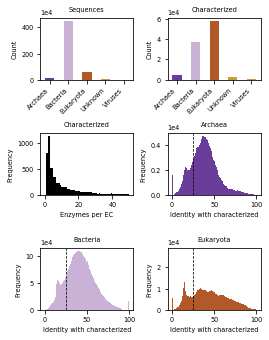

In [6]:
# define font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 6.5}

matplotlib.rc('font', **font)

    
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')
df_html_uid = pd.read_csv(filepath, sep='\t')

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain_2.tsv')
df_html = pd.read_csv(filepath, sep='\t')

df_html_combined = df_html_uid.drop('uid', axis=1).append(df_html) # combine to one frame

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'


ncols = 2
nrows = 3



fig1 = plt.figure(figsize=mm2inch(95, 120), constrained_layout=False)
gs = fig1.add_gridspec(nrows, ncols)
plt.rc('font', size=font_size)

################
## First plot ##
################
f1_ax1 = fig1.add_subplot(gs[0, 0:1])

df_fasta.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.title('Sequences', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xlabel(None)
plt.xticks(rotation=45, ha='right', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

#################
## Second plot ##
#################
f1_ax2 = fig1.add_subplot(gs[0, 1:2])

df_html_combined.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.title('Characterized', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xlabel(None)
plt.xticks(rotation=45, ha='right', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)


################
## Third plot ##
################
f1_ax3 = fig1.add_subplot(gs[1, 0:1])

plt.hist(df_html_combined.groupby('ec').count()['organism'].reset_index()['organism'], 
         bins=50, 
         range=(0, 50),
         color='black')
plt.title('Characterized', fontsize=font_size)
plt.xlabel('Enzymes per EC', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)



################
## Fourth plot ##
################
f1_ax6 = fig1.add_subplot(gs[1, 1:2])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax6.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Archaea'].identity, 
         bins=100, 
         range=(0, 100),
         color=arch_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Archaea', fontsize=font_size)


##################
## Fifth plot ##
##################
f1_ax7 = fig1.add_subplot(gs[2, 0:1])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax7.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Bacteria'].identity, 
         bins=100, 
         range=(0, 100),
         color=bact_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Bacteria', fontsize=font_size)

#################
## Sixth plot ##
#################
f1_ax8 = fig1.add_subplot(gs[2, 1:2])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax8.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Eukaryota'].identity, 
         bins=100, 
         range=(0, 100),
         color=euk_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


#rect = matplotlib.patches.Rectangle((0, 0), width=30, height=f1_ax8.get_ylim()[1], fill='#cdcbc9')
#f1_ax8.add_patch(rect)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Eukaryota', fontsize=font_size)


plt.tight_layout()

plt.savefig(join(FIGURES, 'figure4.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)


plt.savefig(join(FIGURES, 'figure4.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

In [25]:
display('Bacteria mean identity {:.1f}'.format(df_fasta[df_fasta['domain']=='Bacteria'].identity.mean()))
display('Archaea mean identity {:.1f}'.format(df_fasta[df_fasta['domain']=='Archaea'].identity.mean()))
display('Eukaryota mean identity {:.1f}'.format(df_fasta[df_fasta['domain']=='Eukaryota'].identity.mean()))

'Bacteria mean identity 41.4'

'Archaea mean identity 39.0'

'Eukaryota mean identity 46.0'

In [29]:
display('All percentage below 25% identity {:.1f}'.format(100 * df_fasta[df_fasta['identity'] < 25].ec.count() / 
                                               df_fasta.ec.count()))

display('Bacteria percentage below 25% identity {:.1f}'.format(100 * df_fasta[(df_fasta['identity'] < 25) & 
                                                              (df_fasta['domain'] == 'Bacteria')].ec.count() / 
                                                               df_fasta[df_fasta['domain']=='Bacteria'].ec.count()))

display('Archaea percentage below 25% identity {:.1f}'.format(100 * df_fasta[(df_fasta['identity'] < 25) & 
                                                              (df_fasta['domain'] == 'Archaea')].ec.count() / 
                                                              df_fasta[df_fasta['domain']=='Archaea'].ec.count()))

display('Eukaryota percentage below 25% identity {:.1f}'.format(100 * df_fasta[(df_fasta['identity'] < 25) & 
                                                              (df_fasta['domain'] == 'Eukaryota')].ec.count() / 
                                                               df_fasta[df_fasta['domain']=='Eukaryota'].ec.count()))

'All percentage below 25% identity 17.8'

'Bacteria percentage below 25% identity 17.1'

'Archaea percentage below 25% identity 19.2'

'Eukaryota percentage below 25% identity 21.4'

In [13]:
df_fasta.head()

,ec,organism,uid,domain,best_match,ktuple_dist,identity
0,1.1.1.1,Acetatifactor muris,A0A2K4ZQ23,Bacteria,P10127,0.837,32.3
1,1.1.1.1,Acetobacter ghanensis,A0A0U5F1E8,Bacteria,Q8L3C9,0.713,57.8
2,1.1.1.1,Acetobacter ghanensis,A0A0U5F7X9,Bacteria,A4ISB9,0.870,38.3
3,1.1.1.1,Acetobacter ghanensis,A0A0U5F2U0,Bacteria,P9WQC1,0.820,40.5
4,1.1.1.1,Acetobacter malorum,A0A087PNA9,Bacteria,P12311,0.852,29.0


## Supplement

### Show insoluble vs inactive and active

In [ ]:
# we've modified the scoring of active enzymes so the numbers need to be updated in the prop_data df
prop_data.loc[prop_data['total_active'] == 'Yes', 'total_active'] = 'No'
prop_data.loc[prop_data['uid'].isin(both_batches.uid.values), 'total_active'] = 'Yes'


# make the figure
fig = plt.figure(figsize=mm2inch(90, 60))


#################
## First panel ##
#################


# fourth plot, (insoluble, inactive, active, t-SNE plot)
background = (prop_data.total_soluble != 'No') & (prop_data.total_active != 'No') & (prop_data.total_active != 'Yes')
insol = prop_data.total_soluble == 'No'
inact = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'No')
act = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'Yes')

plt.subplot(1, 2, 1)
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)
plt.scatter(my_plot[:,0][insol], my_plot[:,1][insol], s=large_point, color='#5b5b5b')
plt.scatter(my_plot[:,0][inact], my_plot[:,1][inact], s=large_point, color=inactive)
plt.scatter(my_plot[:,0][act], my_plot[:,1][act], s=large_point, color=active)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['Untested', 'Insoluble', 'Inactive', 'Active'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])




##################
## Second panel ##
##################

# fifth plot (sequences per superkingdom, indicating soluble and insoluble fraction, stacked barchart)
plt.subplot(1, 2, 2)

# make a subset to get the sequences of interest
df_subset = prop_data.loc[prop_data['synthesized']=='Yes']
df_subset = df_subset.loc[prop_data['substrate_available']=='Yes']

# count the frequencies
df_temp = df_subset
df_temp.total_active = df_temp.total_active.replace(np.nan, '', regex=True)
result = df_temp.groupby('superkingdom')['total_active'].value_counts(normalize=True)
result = result.unstack().fillna(0)
result = result.reset_index()
result.rename(index=str, columns={'No': 'Inactive', 'Yes': 'Active', '':'Insoluble'}, inplace=True)

# count the total number per category
result_count = df_temp.groupby('superkingdom')['uid'].nunique()
result_count = pd.DataFrame(result_count)
result_count = result_count.reset_index()
result_count.rename(index=str, columns={'uid': 'count'}, inplace=True)

# join the two 
result = result.merge(result_count, on='superkingdom')

display(result)


# now plot
N = len(list(set(result.superkingdom)))
insol = result.Insoluble.values
inact = result.Inactive.values
act = result.Active.values
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, insol, width, 
            color='#5b5b5b')
p2 = plt.bar(ind, inact, width,
             bottom=insol, 
            color=inactive)
p3 = plt.bar(ind, act, width,
             bottom=insol+inact, 
            color=active)

# add labels on top of bars
for i, v in enumerate(result['count'].values):
    plt.text(x=i-0.25, 
             y=1.01, 
             s='n={}'.format(v), 
             color='black', 
             fontweight='normal',
             fontsize=font_size)

# tweak the axis
plt.xticks(ind, result.superkingdom.values, rotation=45)
plt.yticks(np.arange(0, 1.3, 0.2))
plt.legend((p1[0], p2[0], p3[0]), ('Insoluble', 'Inactive', 'Active'),
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel('Category', fontsize=font_size)
plt.ylabel('Fraction', fontsize=font_size)
plt.tick_params(labelsize=font_size)

plt.tight_layout()


plt.savefig(join(FIGURES, 'supplement_insoluble-soluble-active.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'supplement_insoluble-soluble-active.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

### Evaluate quality of the dimensionality reduction by computing all pairwise distances

In [ ]:
# get the distance between MDS representations
mds_dists = []
for i, c1 in enumerate(my_plot):
    for j, c2 in enumerate(my_plot):
        if j > i:
            mds_dists.append(np.linalg.norm(c1-c2))


# get the distance between UniRep representations
rep_dists = []
for i, c1 in enumerate(plot_data):
    for j, c2 in enumerate(plot_data):
        if j > i:
            rep_dists.append(np.linalg.norm(c1-c2))

display(len(mds_dists))
display(len(rep_dists))

In [ ]:
fig = plt.figure(figsize=(3.54, 2.8))
hb = plt.hexbin(rep_dists, mds_dists, 
                cmap='magma_r',
               edgecolors=None)

plt.xticks(np.arange(0, 1800, 400))
plt.yticks(np.arange(0, 1800, 400))
plt.tick_params(labelsize=font_size)

plt.xlabel('UniRep pairwise Euclidian distance', fontsize=font_size)
plt.ylabel('MDS pairwise Euclidian distance', fontsize=font_size)

plt.text(x=50, 
         y=1400, 
         s='n={}'.format(len(rep_dists)), 
         color='black', 
         fontweight='normal',
         fontsize=font_size)

cb = fig.colorbar(hb)
cb.ax.tick_params(labelsize=font_size)
cb.set_label('Count', rotation=270, 
                     labelpad=10, 
                     fontsize=font_size)

plt.tight_layout()

plt.savefig(join(FIGURES, 'supplemental_mds_euclidian_dist_comparison.png'), dpi=300, facecolor='w', 
        edgecolor='w', orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=1, metadata=None)

plt.savefig(join(FIGURES, 'supplemental_mds_euclidian_dist_comparison.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)